# Grupo 6
Rubén Darío Rodríguez Moreno 

Mauricio Alejandro Romejo Jaimes

Daniel Torres

In [ ]:
#@title Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import random as rd
from random import random
from math import log
from google.colab import data_table
data_table.enable_dataframe_formatter()

# Punto 1

In [ ]:
#@title punto 1
def normal_priority(lmbda: list, TiempoServicio: int) -> list:

    """ Primeramente se hacen los calculos discriminando la prioridad es decir como si esta no importara """
    
    # CALCULO DE LA SIGUIENTE LLEGADA Y SERVICIO DEL PRIMER USUARIO
    expRandomLlegada = round(-(1/lmbda[0])*log(random()), 0)
    expRandomCajero = round(-(1/lmbda[1])*log(random()), 0)
    randomPrioridad = 1 if random() < 0.40 else 0
    columns = [
        'tiempo Asignado Llegada Usuario',
        'tiempo Asignado Usuario EnCajero',
        'Prioridad Asignada al usuario',
        'tiempo Llegada Usuario',
        'tiempo Usuario sale Cajero',
        'tiempo Usuario Espera Cajero',
        'tiempo Cajero Espera Usuario',
        'tiempo total del usuario'
    ]

    dataFrame = pd.DataFrame(columns=columns)
    linea = [expRandomLlegada,
             expRandomCajero,
             randomPrioridad,
             expRandomLlegada,
             expRandomLlegada + expRandomCajero,
             0.00,
             expRandomLlegada,
             expRandomCajero]

    dataFrame.loc[0] = linea

    usuarioSaleCajero = linea[4]

    k = 0

    while usuarioSaleCajero < TiempoServicio:

        # DATOS DEL ULTIMO USUARIO
        UltimoUsuario = dataFrame.iloc[-1]
        prioridaUltimoUsuario = UltimoUsuario[2]
        llegadaUltimoUsuario = UltimoUsuario[3]
        salidaUltimoUsuario = UltimoUsuario[4]

        # CALCULO DE LA SIGUIENTE LLEGADA Y SERVICIO DE UN USUARIO
        allegadaUsuario = round(-(1/lmbda[0])*log(random()), 0)
        usuarioEnCajero = round(-(1/lmbda[1])*log(random()), 0)
        prioridadUsuario = 1 if random() < 0.40 else 0

        # CALCULO DE LA LLEGADA Y SALIDA DEL USUARIO
        llegadaUsuario = llegadaUltimoUsuario + allegadaUsuario
        usuarioSaleCajero = salidaUltimoUsuario + usuarioEnCajero

        # CALCULO DE LOS TIEMPOS DE ESPERA
        if (llegadaUsuario > salidaUltimoUsuario): # EL CAJERO ESTABA LIBRE
            usuarioEsperaCajero = 0
            cajeroEsperaUsuario = llegadaUsuario - salidaUltimoUsuario
            usuarioSaleCajero += cajeroEsperaUsuario
            TotalUsuario = usuarioEnCajero
        else: # EL CAJERO ESTABA OCUPADO
            cajeroEsperaUsuario = 0
            usuarioEsperaCajero = salidaUltimoUsuario - llegadaUsuario # tiempo de espera del usuario en cola
            TotalUsuario = usuarioEsperaCajero + usuarioEnCajero

        linea = [allegadaUsuario,
                    usuarioEnCajero,
                    prioridadUsuario,
                    llegadaUsuario,
                    usuarioSaleCajero,
                    usuarioEsperaCajero,
                    cajeroEsperaUsuario,
                    TotalUsuario]
        k += 1
        dataFrame.loc[k] = linea

    print(len(dataFrame))
    
    """ Habra alguna manera de hacer esto mas eficiente pero por ahora funciona """
    """ Ahora se recalculan los tiempos de los usuarios que esperaron """
    i = 0
    rangosOrdenados = []
    while i < len(dataFrame):
        
        if dataFrame.iloc[i][5] != 0:
            UltimoUsuario = dataFrame.iloc[i-1]
            llegadaUltimoUsuario = UltimoUsuario[3]  # este es el tiempo de salida del usuario que hizo esperar a uno o mas usuarios
            salidaUltimoUsuario = UltimoUsuario[4]  # este es el tiempo de llegada del usuario que hizo esperar a uno o mas usuarios
            
            ''' 
                Seleccionamos los usuarios que esperaron desde el ultimo usuario que salio del cajero hasta la ultima llegada antes de esa salida     
            ''' 
            ultimaLlegadas = dataFrame.loc[(dataFrame["tiempo Llegada Usuario"] <= salidaUltimoUsuario) & (dataFrame["tiempo Llegada Usuario"] > llegadaUltimoUsuario)]
            
            
            if len(ultimaLlegadas) > 1 :
                
                '''
                    Ordenamos los usuarios que esperaron por prioridad
                '''
                ultimaLlegadaOrdenada = ultimaLlegadas.sort_values(by=['Prioridad Asignada al usuario'], ascending=False)
                indexes = np.array(ultimaLlegadaOrdenada.index)
                new_i = len(ultimaLlegadas)
                
                if(np.array_equal(indexes, np.array(range(min(indexes), max(indexes)+1)))): # si ya estaban ordenados pasar a la siguiente iteracion
                    i += new_i
                    continue
                rangosOrdenados.append(indexes)
                
                new_i = len(ultimaLlegadas)
                
                ''' recorremos los usuarios que esperaron y recalculamos con el nuevo orden'''
                for j in ultimaLlegadaOrdenada.index:
                    
                    ''' recalcular los tiempos '''
                    usuarioActual = dataFrame.iloc[j]
                    usuarioSaleCajero = UltimoUsuario[4] + usuarioActual[1]
                    usuarioEsperaCajero = UltimoUsuario[4] - usuarioActual[3]
                    TotalUsuario = usuarioEsperaCajero + usuarioActual[1]
                    
                    ''' actualizar los datos del usuario '''
                    dataFrame.loc[j, 'tiempo Usuario sale Cajero'] = usuarioSaleCajero
                    dataFrame.loc[j, 'tiempo Usuario Espera Cajero'] = usuarioEsperaCajero
                    dataFrame.loc[j, 'tiempo total del usuario'] = TotalUsuario
                    
                    ''' El usuario con los tiempos actualizados se convierte en el ultimo usuario en cajero del rango seleccionado(no de todo el dataframe)'''
                    UltimoUsuario = dataFrame.iloc[j]
                

                ''' actualizamos el indice del while '''
                i += new_i

        i = i + 1
    return dataFrame, rangosOrdenados


tiempoServicio = 1440

# Dataframe y los arrays de los grupos de usuarios que se ordenaron dado que habia alguien en prioridad
dt, rangosOrdenados = normal_priority([0.2, 0.3], tiempoServicio)

# Cuando se ejecuta el codigo se puede ver que los usuarios que esperaron estan ordenados por prioridad
# for i in rangosOrdenados:
#     print(i)

dt

280


,tiempo Asignado Llegada Usuario,tiempo Asignado Usuario EnCajero,Prioridad Asignada al usuario,tiempo Llegada Usuario,tiempo Usuario sale Cajero,tiempo Usuario Espera Cajero,tiempo Cajero Espera Usuario,tiempo total del usuario
0,4.0,2.0,0.0,4.0,6.0,0.0,4.0,2.0
1,2.0,24.0,0.0,6.0,30.0,0.0,0.0,24.0
2,1.0,5.0,0.0,7.0,42.0,30.0,0.0,35.0
3,7.0,1.0,1.0,14.0,31.0,16.0,0.0,17.0
4,5.0,1.0,0.0,19.0,43.0,23.0,0.0,24.0
...,...,...,...,...,...,...,...,...
275,0.0,5.0,0.0,1397.0,1423.0,21.0,0.0,26.0
276,3.0,3.0,0.0,1400.0,1426.0,23.0,0.0,26.0
277,1.0,11.0,1.0,1401.0,1437.0,25.0,0.0,36.0
278,11.0,1.0,1.0,1412.0,1438.0,25.0,0.0,26.0


In [ ]:
#@title Datos ya ordenados con las salidas correctas
print("Tabla ordenada por los tiempos de salida")
dt.sort_values(by=['tiempo Usuario sale Cajero'], ascending=True).head(20)


Tabla ordenada por los tiempos de salida


,tiempo Asignado Llegada Usuario,tiempo Asignado Usuario EnCajero,Prioridad Asignada al usuario,tiempo Llegada Usuario,tiempo Usuario sale Cajero,tiempo Usuario Espera Cajero,tiempo Cajero Espera Usuario,tiempo total del usuario
0,4.0,2.0,0.0,4.0,6.0,0.0,4.0,2.0
1,2.0,24.0,0.0,6.0,30.0,0.0,0.0,24.0
3,7.0,1.0,1.0,14.0,31.0,16.0,0.0,17.0
6,1.0,6.0,1.0,24.0,37.0,7.0,0.0,13.0
2,1.0,5.0,0.0,7.0,42.0,30.0,0.0,35.0
4,5.0,1.0,0.0,19.0,43.0,23.0,0.0,24.0
5,4.0,1.0,0.0,23.0,44.0,20.0,0.0,21.0
7,9.0,0.0,0.0,33.0,44.0,11.0,0.0,11.0
8,11.0,1.0,0.0,44.0,45.0,0.0,0.0,1.0
9,9.0,2.0,1.0,53.0,55.0,0.0,8.0,2.0


In [ ]:
#@title ESTADISTICAS PRIORIDAD 0
prioridad_0 = dt[dt['Prioridad Asignada al usuario'] == 0]

print(f"Media del tiempo que espera un usuario el cajero: { round(np.mean(prioridad_0['tiempo Usuario Espera Cajero'])/60,2)} horas en {tiempoServicio/60} horas.")
print(f"Media del tiempo que espera un cajero a un usuario: { np.mean(prioridad_0['tiempo Cajero Espera Usuario'])} minutos en {tiempoServicio/60} horas.")
print(f"Media del tiempo gastado por usuario: { round(np.mean(prioridad_0['tiempo total del usuario']),2)} minutos en {tiempoServicio/60} horas.")
print(f"Personas atendidas en {tiempoServicio/60} horas: {len(prioridad_0)}")
prioridad_0.head(20)


Media del tiempo que espera un usuario el cajero: 0.09 horas en 24.0 horas.
Media del tiempo que espera un cajero a un usuario: 1.9761904761904763 minutos en 24.0 horas.
Media del tiempo gastado por usuario: 9.17 minutos en 24.0 horas.
Personas atendidas en 24.0 horas: 168


,tiempo Asignado Llegada Usuario,tiempo Asignado Usuario EnCajero,Prioridad Asignada al usuario,tiempo Llegada Usuario,tiempo Usuario sale Cajero,tiempo Usuario Espera Cajero,tiempo Cajero Espera Usuario,tiempo total del usuario
0,4.0,2.0,0.0,4.0,6.0,0.0,4.0,2.0
1,2.0,24.0,0.0,6.0,30.0,0.0,0.0,24.0
2,1.0,5.0,0.0,7.0,42.0,30.0,0.0,35.0
4,5.0,1.0,0.0,19.0,43.0,23.0,0.0,24.0
5,4.0,1.0,0.0,23.0,44.0,20.0,0.0,21.0
7,9.0,0.0,0.0,33.0,44.0,11.0,0.0,11.0
8,11.0,1.0,0.0,44.0,45.0,0.0,0.0,1.0
11,3.0,6.0,0.0,56.0,63.0,1.0,0.0,7.0
12,5.0,2.0,0.0,61.0,65.0,2.0,0.0,4.0
13,4.0,2.0,0.0,65.0,67.0,0.0,0.0,2.0


In [ ]:
#@title ESTADISTICAS PRIORIDAD 1
prioridad_1 = dt[dt['Prioridad Asignada al usuario'] == 1]

print(f"Media del tiempo que espera un usuario el cajero: { round(np.mean(prioridad_1['tiempo Usuario Espera Cajero'])/60,2)} horas en {tiempoServicio/60} horas.")
print(f"Media del tiempo que espera un cajero a un usuario: { np.mean(prioridad_1['tiempo Cajero Espera Usuario'])} minutos en {tiempoServicio/60} horas.")
print(f"Media del tiempo gastado por usuario: { round(np.mean(prioridad_1['tiempo total del usuario']),2)} minutos en {tiempoServicio/60} horas.")
print(f"Personas atendidas en {tiempoServicio/60} horas: {len(prioridad_1)}")
prioridad_1.head(20)


Media del tiempo que espera un usuario el cajero: 0.09 horas en 24.0 horas.
Media del tiempo que espera un cajero a un usuario: 1.6160714285714286 minutos en 24.0 horas.
Media del tiempo gastado por usuario: 8.25 minutos en 24.0 horas.
Personas atendidas en 24.0 horas: 112


,tiempo Asignado Llegada Usuario,tiempo Asignado Usuario EnCajero,Prioridad Asignada al usuario,tiempo Llegada Usuario,tiempo Usuario sale Cajero,tiempo Usuario Espera Cajero,tiempo Cajero Espera Usuario,tiempo total del usuario
3,7.0,1.0,1.0,14.0,31.0,16.0,0.0,17.0
6,1.0,6.0,1.0,24.0,37.0,7.0,0.0,13.0
9,9.0,2.0,1.0,53.0,55.0,0.0,8.0,2.0
10,0.0,2.0,1.0,53.0,57.0,2.0,0.0,4.0
15,6.0,1.0,1.0,85.0,86.0,0.0,5.0,1.0
24,18.0,1.0,1.0,147.0,148.0,0.0,6.0,1.0
25,0.0,1.0,1.0,147.0,149.0,1.0,0.0,2.0
26,6.0,7.0,1.0,153.0,160.0,0.0,4.0,7.0
29,2.0,8.0,1.0,168.0,176.0,0.0,1.0,8.0
34,2.0,2.0,1.0,184.0,186.0,0.0,1.0,2.0


# Punto 2

In [ ]:
#@title Autor prenss - simulacion inventario
from random import randint
Periodo = 360
Ne = range(1,Periodo)  #Número de periodos que se hará la simulación 
Zn = [0]  #Número faltante de unidades antes de la orden
Ci = 2    #cantidad en el inventario para el periodo actual
Nf = 0    #Número de unidades faltantes
Xn = [2]  #cantidad en el inventario despues de ordenar al final del periodo n
m  = 0    #la mitad del pedido a realizar
Dem = []  #demandas a lo largo de la operación
ped = []  #guardamos los pedidos
 
for i in Ne:    # i nos da el periodo en el cuál estamos
  D  = randint(0,4)     #generamos las demandas respectivas para este periodo  0,1,2,3,4
  Dem.append(D)             #agregamos a una lista las demandas
  Zn.append(Ci - D)         # calculamos las unidades faltantes
  if Zn[i] < 1:             # revisamos la conclusión para hacer un pedido/ si la condición no se pide el valor de m es 0 por tanto 2m = 0, no se piden unidades
    while Zn[i] + 2*m < 1:  # calculamos el menor valor de m el cual  Zn + 2m >= 1     
      m += 1                
#---la cantidad en inventario después de ordenar al fi nal del periodo-------#
  if Xn[i-1] - D < 1:       
    Xn.append(Xn[i-1]- D + 2*m) # cumplimos la condición para Xn donde si Xn-Dn < 1 entonces Xn = X(n-1)-D+2m 
  else:
    Xn.append(Xn[i-1]- D)       # en el caso complementario Xn-Dn > 1 tendremos que  Xn = X(n-1)-D
                                  
  #el primer caso nos cubre la parte en la cuál la demanda supero el inventario, por tanto debemos
  #realizar un pedido de 2m para el proximo ciclo por eso la ecuación es  Xn = X(n-1)-D+2m 
  # inventario del proximo ciclo = inventario del ciclo actual - demanda del ciclo actual + el pedido
  # al principio del texto dice : "se surte cuando se recibe la siguiente orden"  y pues si no se supero el pedido
  # entonces: inventario del proximo ciclo = inventario del ciclo anterior - la demanda

  Ci = Xn[i]      #Asignamos el ciclo que sera el actual ya que se realizo la orden
  ped.append(2*m) #guardamos el pedido realizado
  m = 0           #reseteamos el pedido

In [ ]:
#@title Dataframe
data = list(zip(Xn, Zn, Dem, ped))
df = pd.DataFrame(data, columns=['Xn', 'Zn', 'Demanda', 'No.pedidos'])
df

,Xn,Zn,Demanda,No.pedidos
0,2,0,4,4
1,2,-2,4,4
2,2,-2,4,4
3,2,-2,1,0
4,1,1,1,2
...,...,...,...,...
354,2,0,1,0
355,1,1,4,4
356,1,-3,3,4
357,2,-2,0,0


In [ ]:
#@title se acerca al estado estable con mas periodos

from collections import Counter
a = Counter(Xn).values()
a = list(a)
print(a[0]/Periodo,a[1]/Periodo)

0.5444444444444444 0.45555555555555555


### Costos definidos en el ejercicio del libro

Costo de inventario sera igual a Zn si este es mayor o igual que 0

Costo de incumplimiento sera igual a -4*Zn si este es < 0

In [ ]:
#@title Costos
# Costo promedio de inventario
positives = [x for x in Zn if x >= 0]
print("Costo promedio de Inventario ",np.mean(positives))
# Costro promedio de incumplimiento
negatives = [abs(x) for x in Zn if x < 0]
print("Costo promedio de Incumplimiento ", np.mean(negatives))


Costo promedio de Inventario  0.8469945355191257
Costo promedio de Incumplimiento  1.8587570621468927


# Punto 4

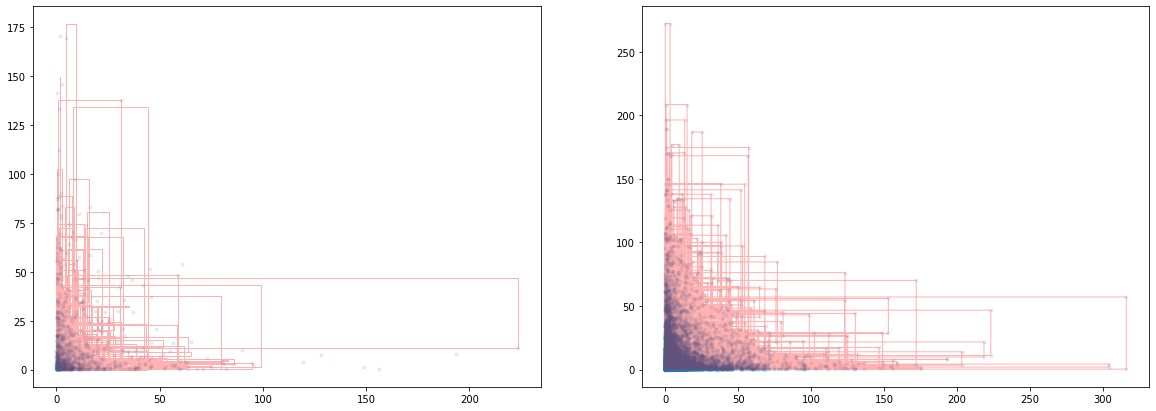

In [ ]:
#@title Gibbs sampling - multiplicacion de dos exponenciales
N = 10000
x = np.zeros(N+1)
y = np.zeros(N+1)
x[0] = 1.
y[0] = 6.

for i in range(1, N, 2):

    x[i] = -(1/0.3)*log(random())*-(1/0.3)*log(random())
    y[i] = y[i-1]

    y[i+1] = -(1/0.3)*log(random())*-(1/0.3)*log(random())
    x[i+1] = x[i]

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(x[::10],y[::10], '.', alpha=0.1)
plt.plot(x[:1000],y[:1000], c='r', alpha=0.3, lw=1)

plt.subplot(1,2,2)
plt.plot(x,y, '.', alpha=0.1)
plt.plot(x,y, c='r', alpha=0.3, lw=1)

In [ ]:
#@title Earlang
from math import e, log, factorial
from random import random

def earlangGenerator(lmbda: float, iterations: int) -> float:
    """
    It generates a random number from an exponential distribution with a given lambda

    :param lmbda: the rate of the exponential distribution
    :type lmbda: float
    :param iterations: number of iterations to run the simulation
    :type iterations: int
    :return: The sum of the random variables.
    """

    earlang = 0
    for i in range(iterations):
        U = random()
        earlang += (-1/lmbda)*log(U)

    return earlang

lmbda = 0.3
iterations = 5

earlangs = []

for u in range(10000):
    earlang = earlangGenerator(lmbda, iterations)
    earlangs.append(earlang)

print(earlangs)



[31.423341150734533, 14.287312306524862, 12.081696704956423, 21.5398760805301, 16.811630065558344, 16.034534732831414, 12.818634991363568, 17.38525088522964, 18.5533586428502, 11.043979469039812, 13.839285361699105, 12.407509172592569, 21.368758372801256, 29.43068224001478, 10.693475438409312, 18.479660361226365, 9.835786245131327, 12.99110636796968, 15.573111646731103, 18.37835064107089, 17.028769181585016, 7.957998755810607, 10.064160921963046, 10.562777218233533, 14.040300414762354, 7.188337238506396, 5.263005250531851, 6.369158621406034, 11.03717523028609, 19.866893639798764, 25.35921883423682, 14.48583776412635, 15.520316019984222, 3.7243342407001845, 8.881249863142603, 12.440943373906716, 12.409282482376039, 21.43888055604615, 14.649008221039859, 17.283269154300733, 15.923672828398853, 15.805095264642663, 18.402409824079825, 9.543912206180398, 11.562350923111781, 16.861334449760168, 9.61811032589511, 10.949002925406326, 5.604430749737404, 16.006164987781084, 15.812141747335676, 2